# Objective

Initial exploration (22 Feb 2019) of blob_log using the RCA sample image. Determine how sensitive the system is to changes to the intensity threshold. Reference annotations by Jenny using Rafael's Matlab spot picker tool.

# Takeaways

Precision behavior and recall behavior are as expected as the intensity threshold changes. The precision-recall curve, with varying intensity threshold, shows an inflection point around 75% precision and 75% recall. The inflection point is less pronounced than the one for the smFISH sample image. That’s probably plenty for just the initial recursive cropping, and then the turkers will take it from there and perform more detailed spot picking. 

The system is sensitive to the intensity threshold on the order of ~ 0.02

# Next Steps

- Automate detection of parameters, rather than by visual inspection
    - parameters including 
        - that intensity threshold inflection point
        - min sigma
        - max sigma
    - this should finish out the pipeline, I think
- Bootstrap on the proportion of actual spots the expert needs to annotate to train our algorithm in order to get good precision and recall

In [1]:
from math import sqrt
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

## Using blob_log to detect spots in smFISH.png
Color larger blobs found purple, smaller blobs cyan.
Using min_sigma = min sigma found with gaussian fit spot parameter extraction (input: image. output: sigma of each spot). max_sigma likewise. threshold found by toggling.

In [2]:
img_height = 450
img_path = 'rca.png'
ref_coords_path = 'rca.csv'
ref_coords_bare_path = 'rca_coords.csv'

## Superimposing spots detected by blob_log with expert annotations.
Color larger blobs found purple, smaller blobs cyan, reference annotations yellow.

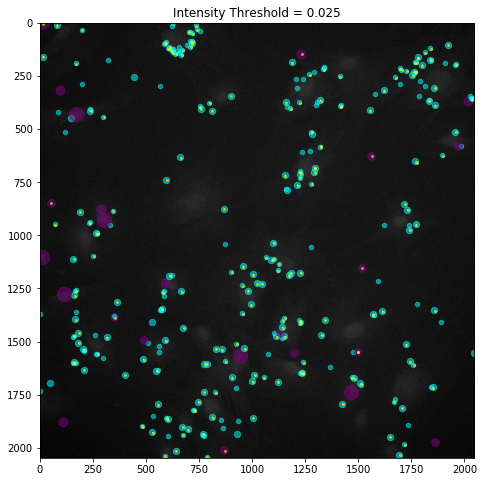

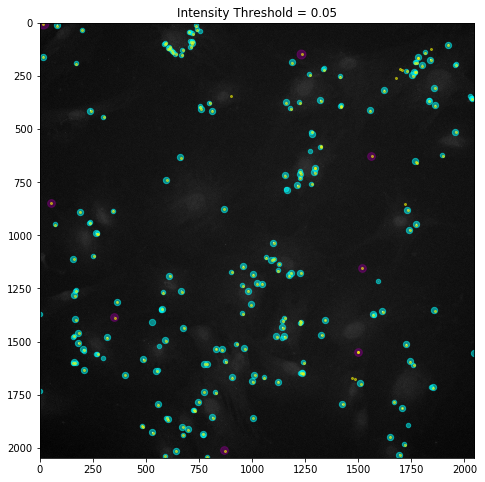

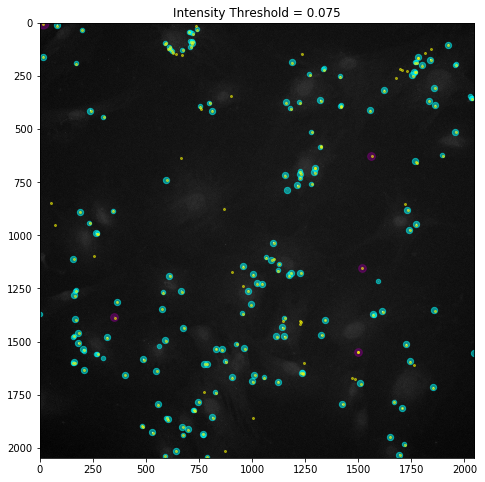

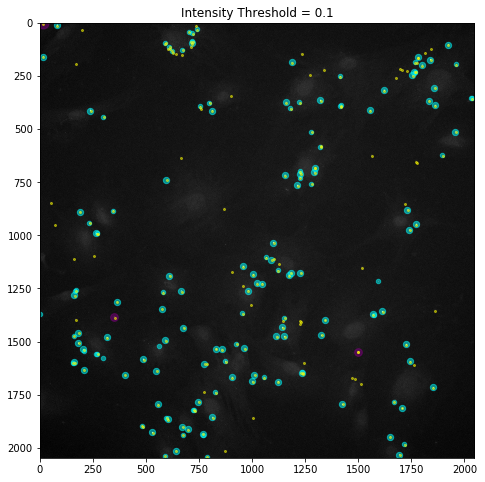

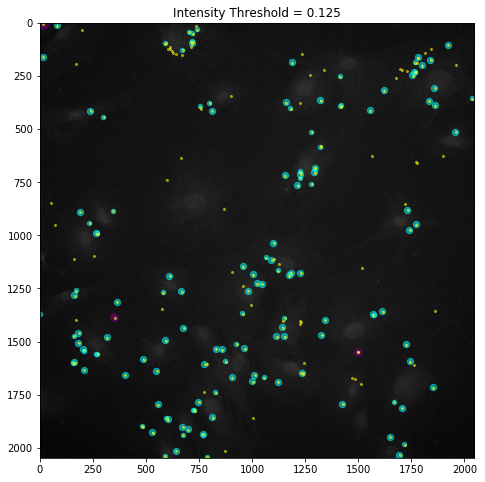

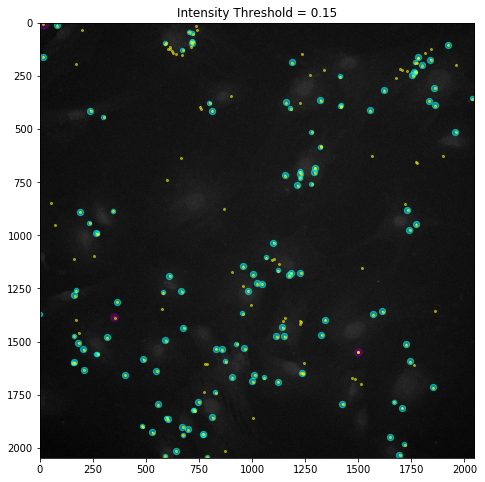

In [4]:
im = imread(img_path)
im_gray = rgb2gray(im)
coords = np.genfromtxt(ref_coords_path, delimiter=',')
for threshold in np.arange(0.025, 0.175, 0.025):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    plt.figure(figsize = (12, 8))
    for r, c, sigma in blobs_log:
        col = 'purple' if sigma > 2 else 'cyan'
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c=col)
    for x, y in coords:
        plt.scatter(x, y, c='yellow', s=4, alpha=0.5)
    plt.gca().invert_yaxis()
    plt.imshow(im_gray, cmap='gray')
    plt.title('Intensity Threshold = ' + str(round(threshold, 3)))
    plt.show()


# Plot Precision-Recall.
(Can't really plot ROC because there aren't "true negatives."

In [5]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

Correctness threshold = 4 pixels.


<Figure size 864x576 with 0 Axes>

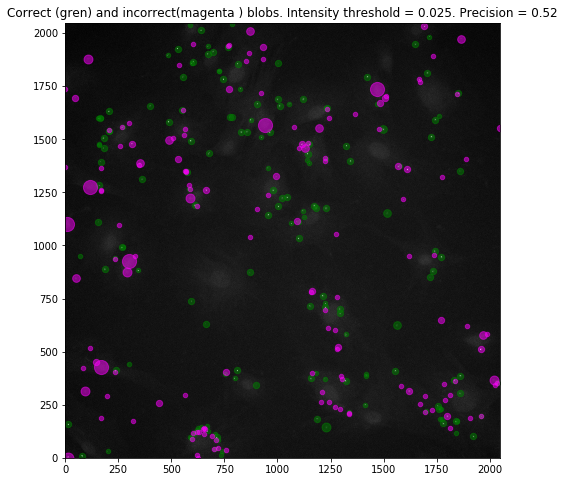

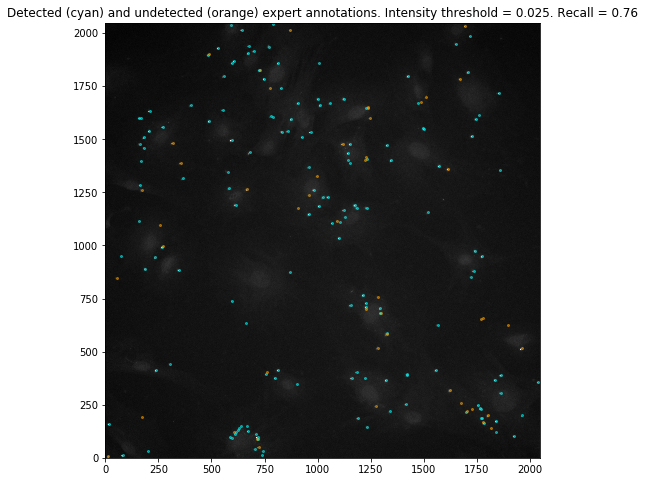

<Figure size 864x576 with 0 Axes>

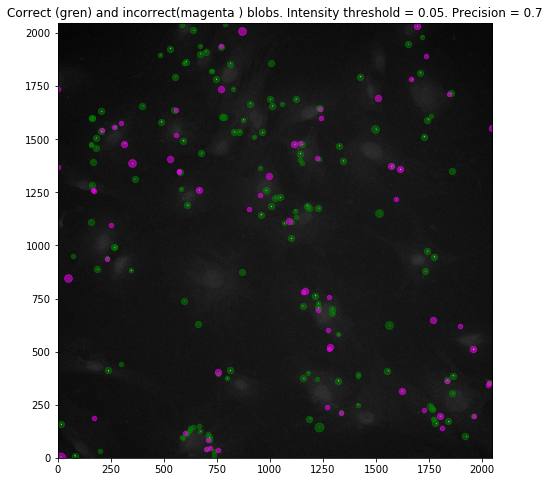

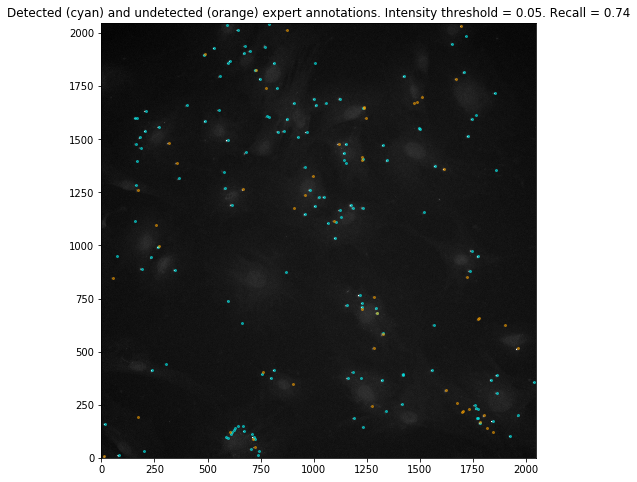

<Figure size 864x576 with 0 Axes>

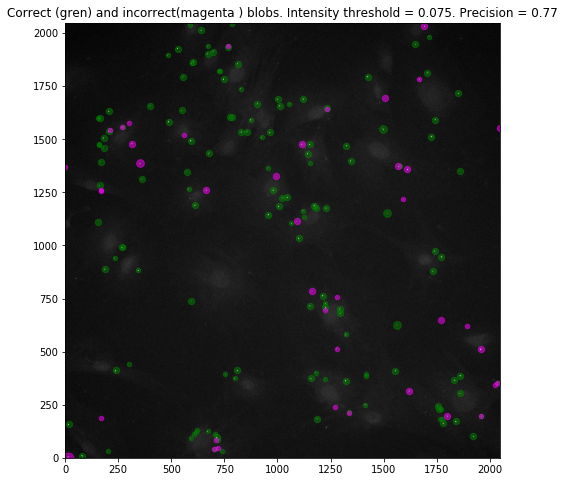

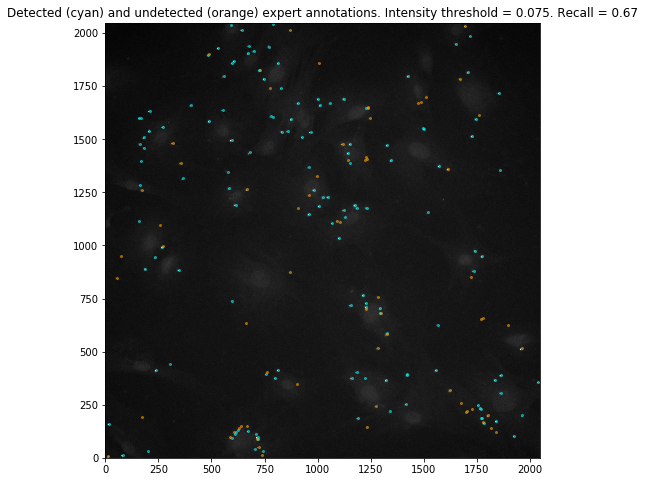

<Figure size 864x576 with 0 Axes>

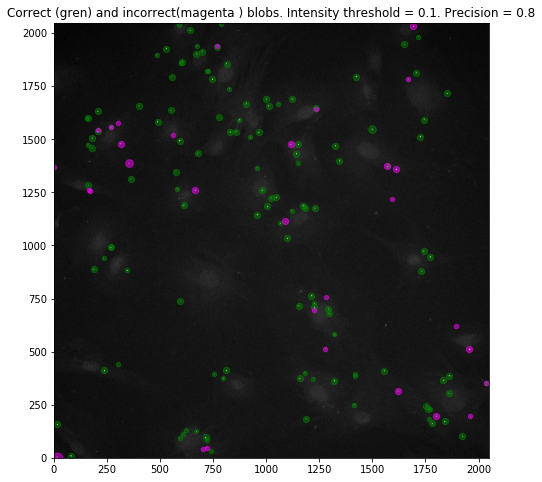

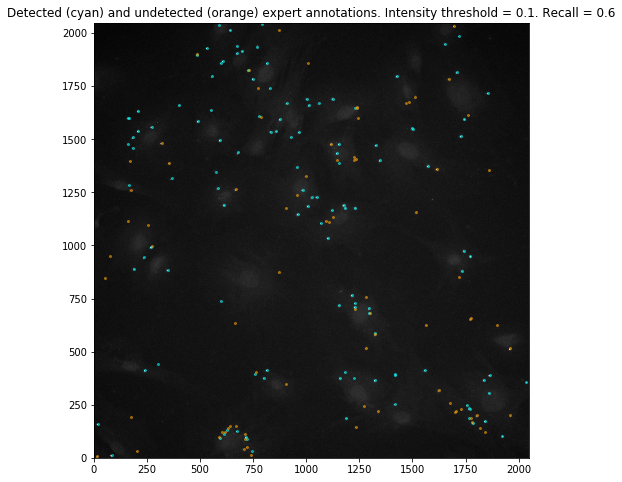

<Figure size 864x576 with 0 Axes>

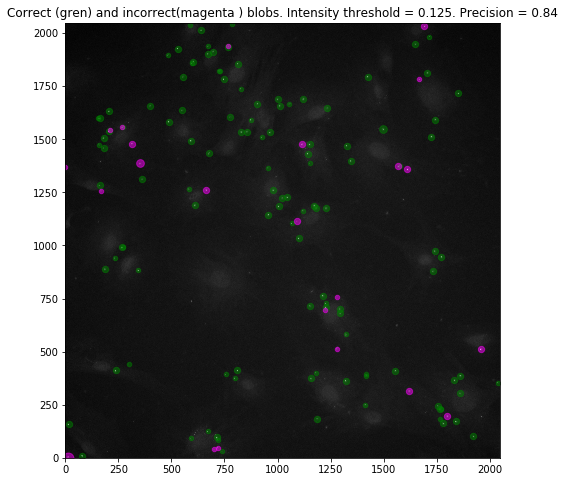

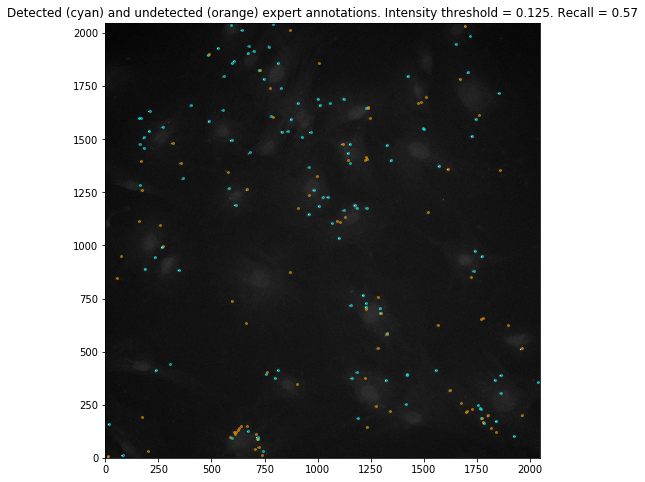

<Figure size 864x576 with 0 Axes>

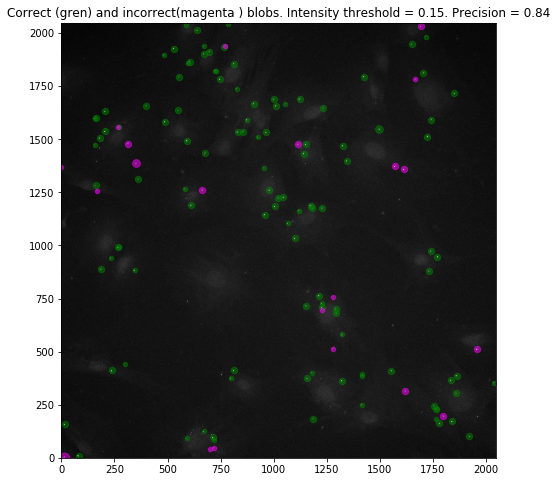

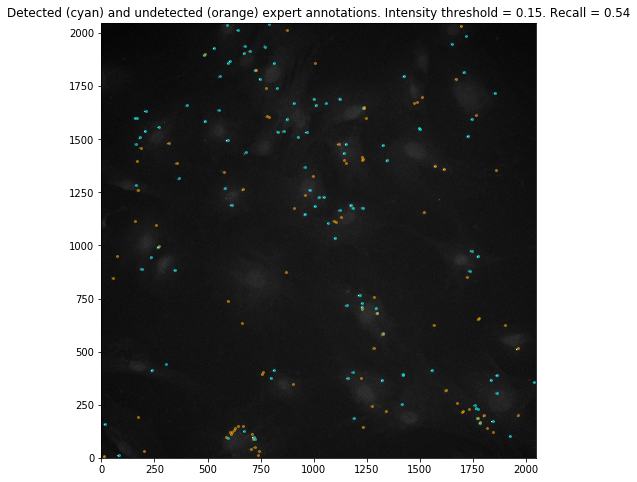

In [10]:
from sklearn.neighbors import KDTree
import sys
sys.path.insert(0, '../../FISH-annotation/Annotation')
import util

correctness_threshold = 4
print('Correctness threshold = ' + str(correctness_threshold) + ' pixels.')

ref_kdt = util.csv_to_kdt(ref_coords_path, img_height)

im = imread(img_path)
im_gray = rgb2gray(im)
ref_coords = np.genfromtxt(ref_coords_bare_path, delimiter=',')

precision_list = []
recall_list = []

for threshold in np.arange(0.025, 0.175, 0.025):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs_list = []
    for r, c, sigma in blobs_log:
        blobs_list.append([c, r])
    blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
    
    plt.figure(figsize=(12, 8))
    
    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    num_ref_detected = len(detected_ref)
    num_blobs_correct = len(correct_blobs)
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    
    # plot correct vs. incorrect

    plt.figure(figsize=(12, 8))
    plt.xlim(0, 2048)
    plt.ylim(0, 2048)
    plt.imshow(im_gray, cmap='gray')
    for r, c, sigma in correct_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='green')
    for r, c, sigma in incorrect_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='magenta')
    plt.title('Correct (green) and incorrect(magenta ) blobs. Intensity threshold = ' + str(round(threshold, 3)) + '. Precision = ' + str(round(precision, 2)))
    plt.show()
    
    # plot detected vs. undetected

    plt.figure(figsize=(12, 8))
    plt.xlim(0, 2048)
    plt.ylim(0, 2048)
    plt.imshow(im_gray, cmap='gray')
    for x, y in detected_ref:
        plt.scatter([x], [y], alpha=0.5, s=4, c='cyan')
    for x, y in undetected_ref:
        plt.scatter([x], [y], alpha=0.5, s=4, c='orange')
    plt.title('Detected (cyan) and undetected (orange) expert annotations. Intensity threshold = ' + str(round(threshold, 3)) + '. Recall = ' + str(round(recall, 2)))
    plt.show()
    
    precision_list.append(precision)
    recall_list.append(recall)
    
    

## Precision Recall Curve

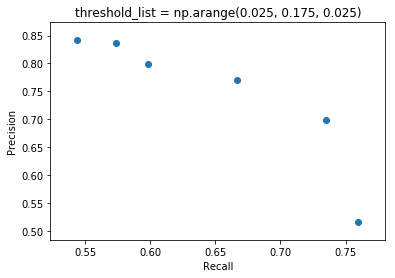

In [11]:
plt.figure()
plt.scatter(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('threshold_list = np.arange(0.025, 0.175, 0.025)')
plt.show()

## Filling in the Precision Recall Curve with more points

Correctness threshold = 4 pixels.


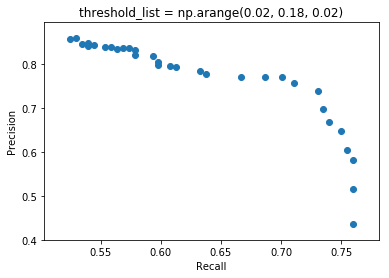

In [12]:
from sklearn.neighbors import KDTree
import sys
sys.path.insert(0, '../FISH-annotation/Annotation')
import util

correctness_threshold = 4
print('Correctness threshold = ' + str(correctness_threshold) + ' pixels.')

ref_kdt = util.csv_to_kdt(ref_coords_path, img_height)

im = imread(img_path)
im_gray = rgb2gray(im)
ref_coords = np.genfromtxt(ref_coords_bare_path, delimiter=',')

precision_list = []
recall_list = []

for threshold in np.arange(0.02, 0.18, 0.005):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs_list = []
    for r, c, sigma in blobs_log:
        blobs_list.append([c, r])
    blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
        
    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    num_ref_detected = len(detected_ref)
    num_blobs_correct = len(correct_blobs)
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    precision_list.append(precision)
    recall_list.append(recall)
    
plt.figure()
plt.scatter(recall_list, precision_list)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('threshold_list = np.arange(0.02, 0.18, 0.02)')
plt.show()
